In [46]:
import pandas as pd
from scipy import stats
import seaborn as sns
import numpy as np
from sklearn import metrics
import statsmodels

In [47]:
def compute_auc(array_1, array_2):
    xs = np.concatenate([array_1, array_2],axis=1)
    y = np.concatenate([array_1.shape[1]*[2], array_2.shape[1]*[1]])
    
    for i, x in enumerate(xs):
        fpr, tpr, thresholds = metrics.roc_curve(y, x, pos_label=2)
        #print(i, metrics.auc(fpr, tpr))
        m = metrics.roc_auc_score(y, x)
        print(round(max(m, 1-m), 2))


def compute_eta_squared(H, n_of_grp,n_of_observ):
    return (H - n_of_grp + 1)/(n_of_observ - n_of_grp)


def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)
            
    return list_object

def kruskal(f, task, c, p, c_name, p_name):
    for i, title in enumerate(task):
        nome = title
        f.write(('\n'+ f'kruskal results for {title} {c_name} {p_name} {stats.kruskal(c[i], p[i]).pvalue} \n\n'))


def read_stats_test(file):
    
    with open(file, 'r') as f:
        lista = []
        testo = f.readlines()
        testo = [line.strip("\n") for line in testo]

        for line in testo:
            if line=="":
                pass
            else:
                lista.append(line)
                
    return lista

def holm_correction(kruskal):
    line_to_remove=[]
    values=[]
    corrected =[]
    final = []
    for l in kruskal:
        if "nan" in l:
            line_to_remove.append(kruskal.index(l))
    
    new_krusk = delete_multiple_element(kruskal, line_to_remove)
            
    for line in new_krusk:
        ok = line.split('vs.')[1]
        num = ok.split(" ")[2]
        values.append(float(num))
   # values = [x for x in values if isnan(x) == False]
    result = statsmodels.stats.multitest.fdrcorrection(values, alpha=0.05, method='indep', is_sorted=False)
    num = np.where(result[0] == True)
    list_index = ((num)[0]).tolist()

    for i in list_index:
        corrected.append(result[1][i])
    for i in list_index:
        final.append(kruskal[i])
    
    return final, corrected


df_30msec = pd.read_csv("/export/b15/afavaro/Frontiers/submission/Statistical_Analysis/Czech/Acoustic/prosody_features_2022-10-21-22-45-47.csv")
df_30msec = df_30msec.drop(columns=['Unnamed: 0'])


df_30msec['label']=df_30msec['AudioFile'].str.split('_').str[0]
tasks = []
names =df_30msec['AudioFile'].tolist()
for e in names:
    ok = e.split("_", 2)[2]
    ok = ok.split("_", 1)[0]
    tasks.append(ok)
df_30msec['tasks'] = tasks
df =df.drop(columns=['AudioFile'])

task = df.groupby("tasks")
read = conc_read = task.get_group("readtext")
monologue = task.get_group("monologue")

## Monologue 

grouped = monologue.groupby("label") #here we extract the values by category
control = grouped.get_group("CN") 
parkinson_ = grouped.get_group("PD")
task = monologue.columns[:-2].values.tolist()
parkinson_all_feat = np.array([parkinson_[feat] for feat in np.array(monologue.columns[:-2])])
control_all_feat = np.array([control[feat] for feat in np.array(monologue.columns[:-2])])

# Statistical Analysis

with open('/export/b15/afavaro/Frontiers/submission/CZECH/ACOUSTIC/Results/monologue_pauses.txt', 'w') as f:
 
    kruskal(f, task, control_all_feat, parkinson_all_feat, "controls vs.", "parkinson")
    
# Apply correction

kruskal_1 = read_stats_test('/export/b15/afavaro/Frontiers/submission/CZECH/ACOUSTIC/Results/monologue_pauses.txt')
holm_correction(kruskal_1)


# Plot

for i, title in enumerate(task):  
    
    nome = title
   
    controls = []
    parkinson=[]
    data = np.concatenate([control_all_feat[i], parkinson_all_feat[i]])
    data = data.tolist()
    data = [float(x) for x in data if x != "None"]
    [controls.append('CN') for value in range(len(control_all_feat[i]))]
    [parkinson.append('PD') for value in range(len(parkinson_all_feat[i]))]
    lista = controls+parkinson
    dict = {nome: data, 'Group': lista} 
    df = pd.DataFrame(dict)
    sns.set(font_scale=2)
    sns.catplot(x=nome, y="Group", kind="boxen", data=df, k_depth='full', palette="Blues",\
               height=4.2, aspect=1.4, showfliers = False)
    
    #plt.savefig(f'/export/b15/afavaro/Frontiers/submission/CZECH/ACOUSTIC/Plots/Pause_Monologue_Read_{nome}.png', facecolor='white', dpi=600)
    
    

In [ ]:
## Read Passage

grouped = read.groupby("label")  #here we extract the values by category
control = grouped.get_group("CN") 
parkinson_ = grouped.get_group("PD")
task = read.columns[:-2].values.tolist()
parkinson_all_feat = np.array([parkinson_[feat] for feat in np.array(read.columns[:-2])])
control_all_feat = np.array([control[feat] for feat in np.array(read.columns[:-2])])

with open('/export/b15/afavaro/Frontiers/submission/CZECH/ACOUSTIC/Results/pauses_read.txt', 'w') as f:
 
    kruskal(f, task, control_all_feat, parkinson_all_feat, "controls vs.", "parkinson")

kruskal_1 = read_stats_test('/export/b15/afavaro/Frontiers/submission/CZECH/ACOUSTIC/Results/pauses_read.txt')
holm_correction(kruskal_1)


/home/afavaro/new_conda/lib/python3.9/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


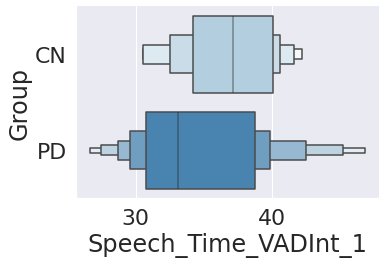

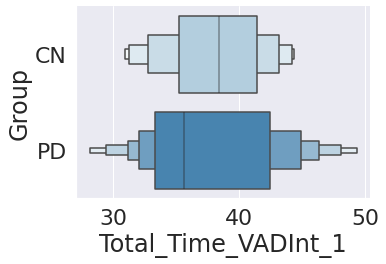

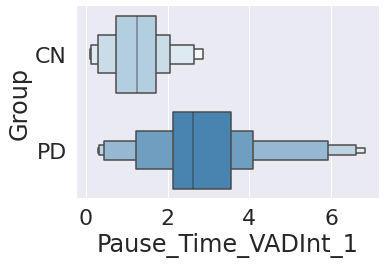

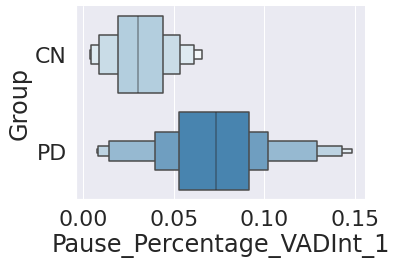

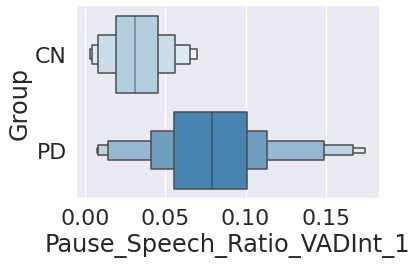

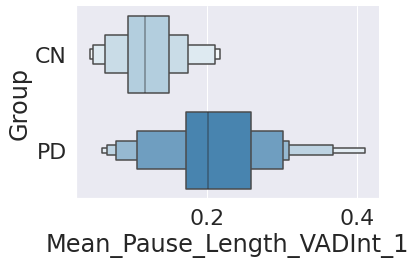

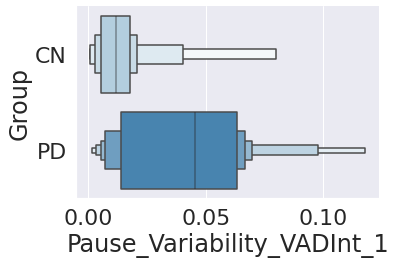

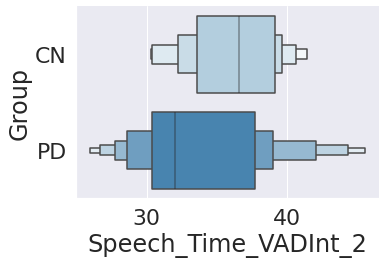

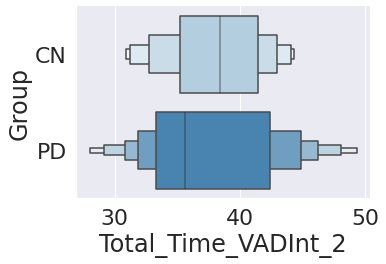

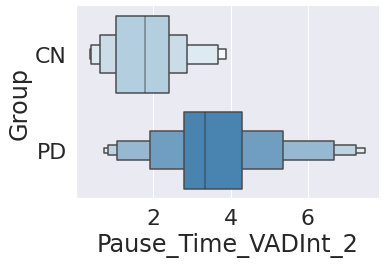

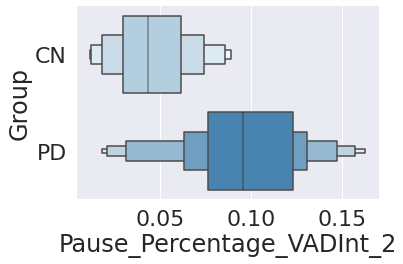

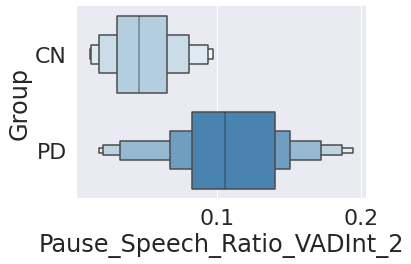

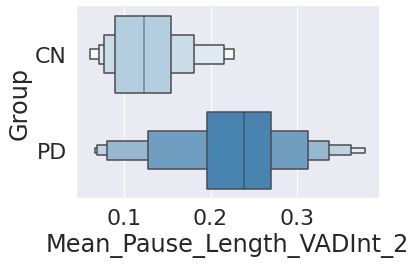

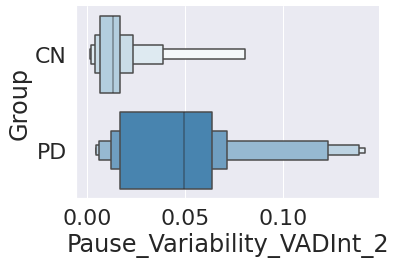

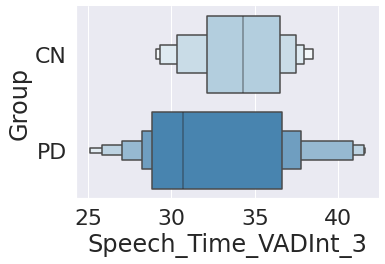

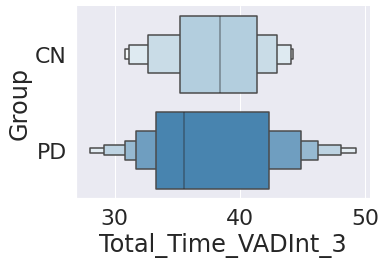

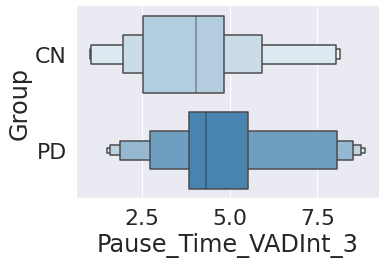

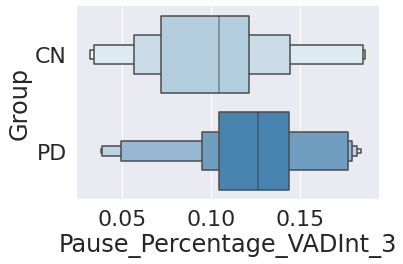

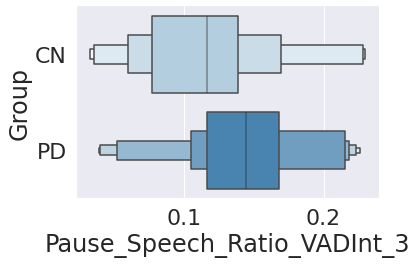

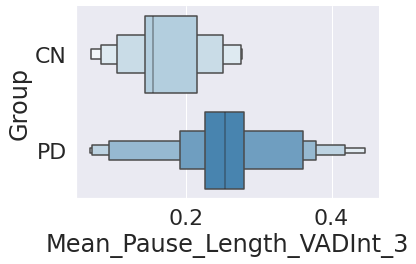

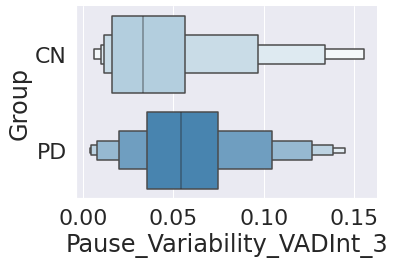

In [59]:
for i, title in enumerate(task):  
    
    nome = title
   
    controls = []
    parkinson=[]
    
    data = np.concatenate([control_all_feat[i], parkinson_all_feat[i]])
    data = data.tolist()
    data = [float(x) for x in data if x != "None"]
    [controls.append('CN') for value in range(len(control_all_feat[i]))]
    [parkinson.append('PD') for value in range(len(parkinson_all_feat[i]))]
    lista = controls+parkinson
    dict = {nome: data, 'Group': lista} 
    df = pd.DataFrame(dict)
    sns.set(font_scale=2)
    sns.catplot(x=nome, y="Group", kind="boxen", data=df, k_depth='full', palette="Blues",\
               height=4.2, aspect=1.4, showfliers = False)
    
   # plt.savefig(f'/export/b15/afavaro/Frontiers/submission/CZECH/ACOUSTIC/Plots/{nome}.png', facecolor='white', dpi=600)